# Masterthesis Maren Kirchner

This code was developed as part of a master's thesis on "Hallucinations in Retrieval-Augmented Language Models: A Novel Detection Frame-work using Natural Language Approaches". As part of the thesis, an NLI-based approach for recognising inconsistent text examples was developed. In this code:



* Guarantee technical requirements
* Load and prepare data
* Create benchmark datasets
* Select model parameters for fine tuning
* Fine tuning of three pre-trained transformer models
* Evaluation of the model with the selected metrics 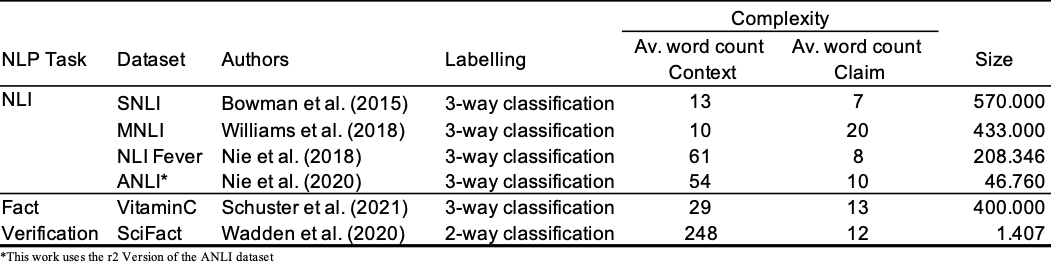



## Technical Requirements

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # This will print True if CUDA is available and correctly installed

# Installations and loading modules

In [ ]:
!pip install datasets
!pip install dataloaders
!pip install transformers datasets
!pip install transformers[torch]
!pip install accelerate -U
!pip install mathplotlib
!pip install sentencepiece
!pip install protobuf
!pip install nltk

# Imports

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import json as js
import random

import re
import string
import os
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from datasets import load_dataset
from datasets import DatasetDict, Dataset
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer, BertTokenizer, BertForSequenceClassification,AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup, Trainer, TrainingArguments, RobertaForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In this work, Google Colab was used and therefore Google Drive was also used to load data. If a different environment is used, the working directory must be adapted.

In [ ]:
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

This code can be customised to set your own WD.

In [ ]:
#path = "/this/is/my/wd"
#set_working_directory(path)

In [ ]:
os.getcwd()

# Load Datasets
Six open source datasets were used in this work, which are uploaded in this section. A summary of the datasets used can be found in the following table.

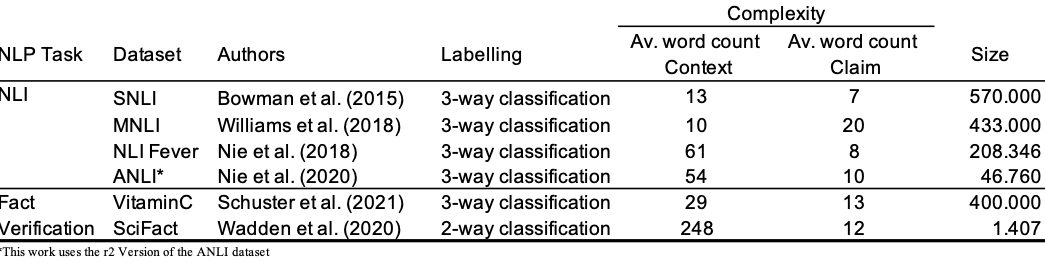


## Scifact (Wadden et al. 2020)
*  https://allenai.org/data/scifact

In [ ]:
#The data set was downloaded as JSON data from the website and is therefore read in here
train_scifact = pd.read_json('claims_train.jsonl', lines=True)
val_scifact = pd.read_json('claims_dev.jsonl', lines=True)
corpus = pd.read_json('corpus.jsonl', lines=True)

#The claims and their associated labels must first be matched with the corpus (evidence)

# Parse each cell in the 'sentence' column which is the evidence
def parse_evidence(cell):
    for doc_id, details in cell.items():
        if details:
            return pd.Series([doc_id, details[0].get('sentences'), details[0].get('label')])
    return pd.Series([None, None, None])

# Apply the function and assign the result to new columns 'evidence'
train_scifact[['doc_id', 'sentences', 'label']] = train_scifact['evidence'].apply(parse_evidence)
val_scifact[['doc_id', 'sentences', 'label']] = val_scifact['evidence'].apply(parse_evidence)

# Convert all labels to string
# Strip whitespace
# Convert to uppercase for uniformity
train_scifact['label'] = train_scifact['label'].astype(str).str.strip().str.upper()
val_scifact['label'] = val_scifact['label'].astype(str).str.strip().str.upper()

# As the data set contains some missing values, the corresponding lines are deleted
# For this purpose, a "_filtered" data record is created that contains the lines with the missing values
# to remove the corresponding lines from the data record in the next step using their 'doc_id'.

train_scifact_filtered = train_scifact[~train_scifact['label'].isin(["NONE", "NAN", ""])]
val_scifact_filtered = val_scifact[~val_scifact['label'].isin(["NONE", "NAN", ""])]
train_scifact_filtered['doc_id'] = train_scifact_filtered['doc_id'].astype('int64')
val_scifact_filtered['doc_id'] = val_scifact_filtered['doc_id'].astype('int64')

train_scifact = pd.merge(train_scifact_filtered, corpus[['doc_id', 'title', 'abstract']], on='doc_id', how='left')
val_scifact = pd.merge(val_scifact_filtered, corpus[['doc_id', 'title', 'abstract']], on='doc_id', how='left')
train_scifact['evidence'] = train_scifact['title'] + " " + train_scifact['abstract'].astype('str')
val_scifact['evidence'] = val_scifact['title'] + " " + val_scifact['abstract'].astype('str')


## In this step, the labelling is converted into a numerical code that is applied to all data records to ensure uniformity.
label_mapping = {'CONTRADICT': 0, 'SUPPORT': 1}

train_scifact['label'] = train_scifact['label'].map(label_mapping)
train_scifact['label'] = train_scifact['label'].astype('int64')
val_scifact['label'] = val_scifact['label'].map(label_mapping)
val_scifact['label'] = val_scifact['label'].astype('int64')

To gain an initial understanding of the data, 20 examples are selected at random.

In [ ]:
scifact_train_examples = train_scifact.sample(n=20)
scifact_train_examples

In [ ]:
scifact_val_examples = val_scifact.sample(n=20)
scifact_val_examples

## MNLI (Williams et al. 2018)

* https://huggingface.co/datasets/nyu-mll/multi_nli

In [ ]:
#Load MNLI Dataset from Working Directory
mnli_train = pd.read_csv('mnli_train.csv')
mnli_val = pd.read_csv('mnli_val.csv')

#rename columns
datasets = [mnli_train, mnli_val]

for df in datasets:
    df.rename(columns={'premise': 'claim'}, inplace=True)
    df.rename(columns={'hypothesis': 'evidence'}, inplace=True)

As discussed in the Study for the two-label-classification the MNLI Dataset will be transformed into a balanced two-label dataset (Support, Contradict) according to Honovich et al. (2022)


In [ ]:
mnli_train_2 = mnli_train.copy()
mnli_val_2 = mnli_val.copy()

datasets = [mnli_train_2, mnli_val_2]

for df in datasets:
  df['label'] = df['label'].apply(lambda x: 1 if x == 2 else x)


Create a balanced dataset for MNLI Train Split

In [ ]:
data_label_0 = mnli_train_2[mnli_train_2['label'] == 0]
data_label_1 = mnli_train_2[mnli_train_2['label'] == 1]

#min count per label
min_count = min(len(data_label_0), len(data_label_1))

# balaced number of observations
balanced_data_0 = data_label_0.sample(n=min_count, random_state=42)
balanced_data_1 = data_label_1.sample(n=min_count, random_state=42)

# Merge
bmnli_train_2 = pd.concat([balanced_data_0, balanced_data_1])

# mix datasets
bmnli_train_2 = bmnli_train_2.sample(frac=1, random_state=42).reset_index(drop=True)
print(bmnli_train_2['label'].value_counts())

Create a balanced dataset for MNLI Validation Split

In [ ]:

data_label_0 = mnli_val_2[mnli_val_2['label'] == 0]
data_label_1 = mnli_val_2[mnli_val_2['label'] == 1]

#min count per label
min_count = min(len(data_label_0), len(data_label_1))

# balaced number of observations
balanced_data_0 = data_label_0.sample(n=min_count, random_state=42)
balanced_data_1 = data_label_1.sample(n=min_count, random_state=42)

# Merge
bmnli_val_2 = pd.concat([balanced_data_0, balanced_data_1])

# mix datasets
bmnli_val_2 = bmnli_val_2.sample(frac=1, random_state=42).reset_index(drop=True)
print(bmnli_val_2['label'].value_counts())

In [ ]:
mnli_train_examples = mnli_train.sample(n=20)
mnli_train_examples

In [ ]:
mnli_val_examples = mnli_val.sample(n=20)
mnli_val_examples

## Vitamin C (Shuster et al. 2021)
* https://huggingface.co/datasets/tals/vitaminc

In [ ]:
#Dataset will be downloaded directly from Hugging Face
train_vc = pd.DataFrame(load_dataset("tals/vitaminc", split='train'))
val_vc = pd.DataFrame(load_dataset("tals/vitaminc", split='validation'))

In [ ]:
#rename columns for uniformity
datasets = [train_vc, val_vc]

for df in datasets:
    df.rename(columns={'query': 'claim'}, inplace=True)
    df.rename(columns={'context': 'evidence'}, inplace=True)

    # Map labels to numerical values
    label_mapping = {'SUPPORTS': 0, 'NOT ENOUGH INFO': 1, 'REFUTES': 2}
    df['label'] = df['label'].replace(label_mapping).astype('int64')

As discussed in the Study for the two-label-classification the Vitamin C Dataset will be transformed into a balanced two-label dataset (Support, Contradict) according to Honovich et al. (2022)


In [ ]:
train_vc_2 = train_vc.copy()
val_vc_2 = val_vc.copy()

datasets = [train_vc_2, val_vc_2]

for df in datasets:
  df['label'] = df['label'].apply(lambda x: 1 if x == 2 else x)


Create a balanced dataset for Vitamin C Train Split


In [ ]:
data_label_0 = train_vc_2[train_vc_2['label'] == 0]
data_label_1 = train_vc_2[train_vc_2['label'] == 1]

#min count per label
min_count = min(len(data_label_0), len(data_label_1))

# balaced number of observations
balanced_data_0 = data_label_0.sample(n=min_count, random_state=42)
balanced_data_1 = data_label_1.sample(n=min_count, random_state=42)

# Merge
btrain_vc_2 = pd.concat([balanced_data_0, balanced_data_1])

# mix datasets
btrain_vc_2 = btrain_vc_2.sample(frac=1, random_state=42).reset_index(drop=True)
print(btrain_vc_2['label'].value_counts())

Create a balanced dataset for Vitamin C Train Split

In [ ]:
data_label_0 = val_vc_2[val_vc_2['label'] == 0]
data_label_1 = val_vc_2[val_vc_2['label'] == 1]

#min count per label
min_count = min(len(data_label_0), len(data_label_1))

# balaced number of observations
balanced_data_0 = data_label_0.sample(n=min_count, random_state=42)
balanced_data_1 = data_label_1.sample(n=min_count, random_state=42)

# Merge
bval_vc_2 = pd.concat([balanced_data_0, balanced_data_1])

# mix datasets
bval_vc_2 = bval_vc_2.sample(frac=1, random_state=42).reset_index(drop=True)
print(bval_vc_2['label'].value_counts())

In [ ]:
vc_train_examples = train_vc.sample(n=20)
vc_train_examples

In [ ]:
vc_val_examples = train_vc.sample(n=20)
vc_val_examples

## NLI Fever (Nie et al. 2018)

* https://huggingface.co/datasets/pietrolesci/nli_fever

In the following data set, only the train split is labelled so that the validation split and test split are not downloaded. When experimenting, care should be taken to ensure that the data set is not used for model training and evaluation at the same time.






In [ ]:
#NLI Fever
train_nlifever = pd.read_json('train_nlifever.jsonl', lines=True)

In [ ]:
#rename columns for uniformity
datasets = [train_nlifever]

for df in datasets:
    df.rename(columns={'query': 'claim'}, inplace=True)
    df.rename(columns={'context': 'evidence'}, inplace=True)

    # Map labels to numerical values
    label_mapping = {'SUPPORTS': 0, 'NOT ENOUGH INFO': 1, 'REFUTES': 2}
    df['label'] = df['label'].replace(label_mapping)


As discussed in the study for the two-label-classification the NLI Fever Dataset will be transformed into a balanced two-label dataset (Support, Contradict) according to Honovich et al. (2022)


In [ ]:
train_nlifever_2 = train_nlifever.copy()

datasets = [train_nlifever_2]

for df in datasets:
  df['label'] = df['label'].apply(lambda x: 1 if x == 2 else x)

rtrain_nlifever_2 = train_nlifever_2.sample(n=10000, random_state=42)

Create a balanced dataset for NLI FEVER Train Split

In [ ]:
data_label_0 = train_nlifever_2[train_nlifever_2['label'] == 0]
data_label_1 = train_nlifever_2[train_nlifever_2['label'] == 1]

#min count per label
min_count = min(len(data_label_0), len(data_label_1))

# balaced number of observations
balanced_data_0 = data_label_0.sample(n=min_count, random_state=42)
balanced_data_1 = data_label_1.sample(n=min_count, random_state=42)

# Merge
btrain_nlifever_2 = pd.concat([balanced_data_0, balanced_data_1])

# mix datasets
btrain_nlifever_2 = btrain_nlifever_2.sample(frac=1, random_state=42).reset_index(drop=True)
print(btrain_nlifever_2['label'].value_counts())

In [ ]:
nlifever_train_examples = train_nlifever.sample(n=20)
nlifever_train_examples

##SNLI (Bowman et al. 2015)
* https://huggingface.co/datasets/stanfordnlp/snli

In [ ]:
train_snli = pd.DataFrame(load_dataset("snli", split='train'))
val_snli = pd.DataFrame(load_dataset("snli", split='validation'))

In [ ]:
datasets = [train_snli, val_snli]

for df in datasets:
    df.rename(columns={'hypothesis': 'claim'}, inplace=True)
    df.rename(columns={'premise': 'evidence'}, inplace=True)


As discussed in the study for the two-label-classification the SNLI Dataset will be transformed into a balanced two-label dataset (Support, Contradict) according to Honovich et al. (2022)


In [ ]:
##SNLI to 2 classes
train_snli_2 = train_snli.copy()
val_snli_2 = val_snli.copy()

datasets = [train_snli_2, val_snli_2]

for df in datasets:
  df['label'] = df['label'].apply(lambda x: 1 if x == 2 else x)

Create a balanced dataset for SNLI Train Split

In [ ]:
data_label_0 = train_snli_2[train_snli_2['label'] == 0]
data_label_1 = train_snli_2[train_snli_2['label'] == 1]

#min count per label
min_count = min(len(data_label_0), len(data_label_1))

# balaced number of observations
balanced_data_0 = data_label_0.sample(n=min_count, random_state=42)
balanced_data_1 = data_label_1.sample(n=min_count, random_state=42)

# Merge
btrain_snli_2 = pd.concat([balanced_data_0, balanced_data_1])

# mix datasets
btrain_snli_2 = btrain_snli_2.sample(frac=1, random_state=42).reset_index(drop=True)
print(btrain_snli_2['label'].value_counts())

Create a balanced dataset for SNLI Validation Split

In [ ]:
data_label_0 = val_snli_2[val_snli_2['label'] == 0]
data_label_1 = val_snli_2[val_snli_2['label'] == 1]

#min count per label
min_count = min(len(data_label_0), len(data_label_1))

# balaced number of observations
balanced_data_0 = data_label_0.sample(n=min_count, random_state=42)
balanced_data_1 = data_label_1.sample(n=min_count, random_state=42)

# Merge
bval_snli_2 = pd.concat([balanced_data_0, balanced_data_1])

# mix datasets
bval_snli_2 = bval_snli_2.sample(frac=1, random_state=42).reset_index(drop=True)
print(bval_snli_2['label'].value_counts())

In [ ]:
snli_train_examples = train_snli.sample(n=20)
snli_train_examples

In [ ]:
snli_val_examples = train_snli.sample(n=20)
snli_val_examples

## ANLI (Nie et al. 2020)

* https://huggingface.co/datasets/facebook/anli

In [ ]:
train_anli = pd.read_json('anli_train.jsonl', lines=True)
val_anli = pd.read_json('anli_dev.jsonl', lines=True)

As discussed in the study for the two-label-classification the ANLI Dataset will be transformed into a balanced two-label dataset (Support, Contradict) according to Honovich et al. (2022)

In [ ]:
datasets = [train_anli, val_anli]

for df in datasets:
    df.rename(columns={'hypothesis': 'claim'}, inplace=True)
    df.rename(columns={'context': 'evidence'}, inplace=True)

        # Map labels to numerical values
    label_mapping = {'e': 0, 'n': 1, 'c': 2}
    df['label'] = df['label'].replace(label_mapping).astype('int64')

As discussed in the study for the two-label-classification the SNLI Dataset will be transformed into a balanced two-label dataset (Support, Contradict) according to Honovich et al. (2022)

In [ ]:
train_anli_2 = train_anli.copy()
val_anli_2 = val_anli.copy()

datasets = [train_anli_2, val_anli_2]

for df in datasets:
  df['label'] = df['label'].apply(lambda x: 1 if x == 2 else x)

rtrain_anli_2 = train_anli_2.sample(n=10000, random_state=42)
rval_anli_2 = val_anli_2.sample(n=1000, random_state=42)

Create a balanced dataset for ANLI Train Split

In [ ]:
data_label_0 = train_anli_2[train_anli_2['label'] == 0]
data_label_1 = train_anli_2[train_anli_2['label'] == 1]

#min count per label
min_count = min(len(data_label_0), len(data_label_1))

# balaced number of observations
balanced_data_0 = data_label_0.sample(n=min_count, random_state=42)
balanced_data_1 = data_label_1.sample(n=min_count, random_state=42)

# Merge
btrain_anli_2 = pd.concat([balanced_data_0, balanced_data_1])

# mix datasets
btrain_anli_2 = btrain_anli_2.sample(frac=1, random_state=42).reset_index(drop=True)
print(btrain_anli_2['label'].value_counts())

Create a balanced dataset for ANLI Validation Split

In [ ]:

data_label_0 = val_anli_2[val_anli_2['label'] == 0]
data_label_1 = val_anli_2[val_anli_2['label'] == 1]

#min count per label
min_count = min(len(data_label_0), len(data_label_1))

# balaced number of observations
balanced_data_0 = data_label_0.sample(n=min_count, random_state=42)
balanced_data_1 = data_label_1.sample(n=min_count, random_state=42)

# Merge
bval_anli_2 = pd.concat([balanced_data_0, balanced_data_1])

# mix datasets
bval_anli_2 = bval_anli_2.sample(frac=1, random_state=42).reset_index(drop=True)
print(bval_anli_2['label'].value_counts())

In [ ]:
anli_train_examples = train_anli.sample(n=20)
anli_train_examples

In [ ]:
anli_val_examples = train_anli.sample(n=20)
anli_val_examples

## Comnbined datasets
Create new benchmark dataset as combinations of the datasets above


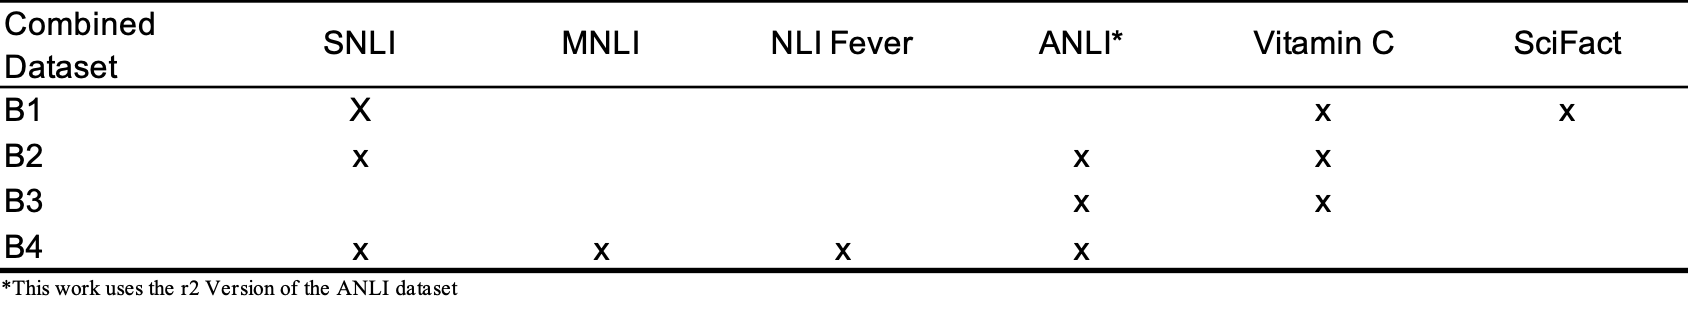

###B1 (2 label dataset)
* SciFcat
* Vitamin C
* SNLI

In [ ]:
B1 = pd.merge(train_scifact, btrain_vc_2, on=['claim', 'evidence', 'label'], how='outer')
B1 = pd.merge(B1,btrain_snli_2,  on=['claim', 'evidence', 'label'], how='outer')
B1 = B1[['label','claim','evidence']]

###B2

* ANLI
* Vitamin C
* SNLI

Three label Benchmark

In [ ]:
B2 = pd.merge(train_anli, train_vc, on=['claim', 'evidence', 'label'], how='outer')
B2 = pd.merge(B2,train_snli,  on=['claim', 'evidence', 'label'], how='outer')
B2 = B2[['label','claim','evidence']]

Two label Benchmark

In [ ]:
B2_2 = pd.merge(btrain_anli_2, btrain_vc_2, on=['claim', 'evidence', 'label'], how='outer')
B2_2 = pd.merge(B2_2,btrain_snli_2,  on=['claim', 'evidence', 'label'], how='outer')
B2_2 = B2_2[['label','claim','evidence']]

###B3

* ANLI
* Vitamin C

Three label Benchmark

In [ ]:
B3 = pd.merge(train_anli, train_vc, on=['claim', 'evidence', 'label'], how='outer')
B3 = B3[['label','claim','evidence']]

Two label Benchmark

In [ ]:
B3_2 = pd.merge(btrain_anli_2, btrain_vc_2, on=['claim', 'evidence', 'label'], how='outer')
B3_2 = B3_2[['label','claim','evidence']]

###B4

* ANLI
* MNLI
* SNLI
* NLI Fever

Three label Benchmark

In [ ]:
B4 = pd.merge(train_anli, mnli_train, on=['claim', 'evidence', 'label'], how='outer')
B4 = pd.merge(B4,train_snli,  on=['claim', 'evidence', 'label'], how='outer')
B4 = pd.merge(B4,train_nlifever,  on=['claim', 'evidence', 'label'], how='outer')
B4 = B4[['label','claim','evidence']]

Two label Benchmark

In [ ]:
B4_2 = pd.merge(btrain_anli_2, bmnli_train_2, on=['claim', 'evidence', 'label'], how='outer')
B4_2 = pd.merge(B4_2,btrain_snli_2,  on=['claim', 'evidence', 'label'], how='outer')
B4_2 = pd.merge(B4_2,btrain_nlifever_2,  on=['claim', 'evidence', 'label'], how='outer')
B4_2 = B4_2[['label','claim','evidence']]

# Data understanding and preparation

In this step, the respective train and validation data set that will be used in the further process must be defined.

**!!Manual to do here!!**

In [ ]:
#define Train and Val
train = B3
val = val_snli

#adjust based on your actual number of classes
num_labels = 3

In [ ]:
val.info()

In [ ]:
train.info()

In [ ]:
#Select just the important columns if necessaary
train = train[['label','claim','evidence']]
val = val[['label','claim','evidence']]

In [ ]:
#Check if the labelling was correct
val['label'].unique()

In [ ]:
#Check if the labelling was correct
train['label'].unique()

In [ ]:
print(train['label'].value_counts(normalize=True) * 100)

In [ ]:
print(val['label'].value_counts(normalize=True) * 100)

### Missing Values

In [ ]:
# Check for missing values
missing_values_train = train.isnull().sum()
print("Missing values in each column:\n", missing_values_train)
missing_values_val = val.isnull().sum()
print("Missing values in each column:\n", missing_values_val)
train.dropna(inplace=True)

Check for values out of the label class range



In [ ]:
### Train
out_of_range_labels = train[(train['label'] < 0) | (train['label'] >= num_labels)]
out_of_range_labels.count()

if not out_of_range_labels.empty:
    print("Found labels out of the expected range:\n", out_of_range_labels)
    train = train[(train['label'] >= 0) & (train['label'] < num_labels)]

# safe labels as integer
train['label'] = train['label'].astype(int)

In [ ]:
### Validation
out_of_range_labels = val[(val['label'] < 0) | (val['label'] >= num_labels)]
out_of_range_labels.count()

if not out_of_range_labels.empty:
    print("Found labels out of the expected range:\n", out_of_range_labels)
    val = val[(val['label'] >= 0) & (val['label'] < num_labels)]

# safe labels as integer
val['label'] = val['label'].astype(int)

In [ ]:
# Some Datasets contain Values of -1 which I delete in this step
val = val.loc[val['label'] != -1]
train = train.loc[train['label'] != -1]

### Analyse Datasets

In [ ]:
# Label distribution Train dataset
train['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [ ]:
# Label distribution Validation dataset
val['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

Get the maximum sequence length

In [ ]:
max_sequence_length_claim_val = val['claim'].str.len().max()
max_sequence_length_claim_train= train['claim'].str.len().max()
max_sequence_length_evidence_val = val['evidence'].str.len().max()
max_sequence_length_evidence_train= train['evidence'].str.len().max()

print(max_sequence_length_claim_val)
print(max_sequence_length_claim_train)
print(max_sequence_length_evidence_val)
print(max_sequence_length_evidence_train)

## Average token length
As transformers often have a maximum input length of tokens, it is checked here whether the texts are not longer on average than the Max Token Length in order not to exceed the information at which the texts are cut off

In [ ]:
nltk.download('punkt')

# Definie function to count token
def token_count(text):
    tokens = word_tokenize(text)
    return len(tokens)

# Calculate Token count for Train in 'claim' and 'Evicence'
train['claim_token_count'] = train['claim'].apply(token_count)
train['evidence_token_count'] = train['evidence'].apply(token_count)
val['claim_token_count'] = val['claim'].apply(token_count)
val['evidence_token_count'] = val['evidence'].astype('str').apply(token_count)


In [ ]:
max_sequence_length_claim_train = train['claim_token_count'].max()
max_sequence_length_evidence_train = train['evidence_token_count'].max()
max_sequence_length_claim_val = val['claim_token_count'].max()
max_sequence_length_evidence_val = val['evidence_token_count'].max()

print(max_sequence_length_claim_train)
print(max_sequence_length_evidence_train)
print(max_sequence_length_claim_val)
print(max_sequence_length_evidence_val)

In [ ]:
# Calculate the average length per column
average_claim_token_train = train['claim_token_count'].mean()
average_evidence_token_train= train['evidence_token_count'].mean()
average_claim_token_val = val['claim_token_count'].mean()
average_evidence_token_val = val['evidence_token_count'].mean()

print(f'The average word count of the claim (Train) is: {round(average_claim_token_train,0)}')

print(f'The average word count of the evidence (Train)is: {round(average_evidence_token_train,0)}')

print(f'The average token count of the claim (Validation) is: {round(average_claim_token_val,0)}')

print(f'The average token count of the evidence (Validation) is: {round(average_evidence_token_val,0)}')

The analysis shows that all data records have an average token length significantly below the maximum input length. Only the SciFact data set contains exeeded texts. This is taken into account when analysing the results in the study.

In [ ]:
#Select just the important columns
train = train[['label','claim','evidence']]
val = val[['label','claim','evidence']]

# Model settings

As explained in the study, only a data set of 20,000 text pairs can be used in the training split and 5,000 text pairs in the validation split due to the limited computing capacity. A random_state = 42 is set for reproducibility.

In [ ]:
train = train.sample(n=20000, random_state=42)
val= val.sample(n=5000, random_state=42)

**!!Manual to do here!!**

In [ ]:
num_label = 3
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model checkpoints
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_ratio=0.1,                # percentage that is used for warm up phase
    weight_decay=0.01,               # strength of weight decay #0,01 in docu
    evaluation_strategy="epoch",      # evaluate each `logging_steps`
    logging_dir='./logs',            # directory for storing logs
)

# Fine Tuning

Three transformer models were fine-tuned as part of the study. The code for fine-tuning each model is listed below. The parameters listed above are applied to the models.

## Bert-based-uncased (Devlin et al. 2019)
* https://huggingface.co/google-bert/bert-base-uncased

### Tokenization

In [ ]:
model = 'bert-base-uncased'

claim_train = train['claim'].astype(str)
evidence_train = train['evidence'].astype(str)

#Use of pretrained AutoTokenizer from Hugging Face for the selected model
tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_data = tokenizer(
    claim_train.astype(str).tolist(),
    evidence_train.astype(str).tolist(),
    padding=True, truncation=True,
    return_tensors="pt")

As transformer models require tensors as input, the output of the tokenizer is then con-verted to tensors in preparation for fine-tuning using the PyTorch  module

Train

In [ ]:
labels_tensor = torch.tensor(train['label'].tolist())
labels_train = labels_tensor.clone().detach().long()

input_ids_train = tokenized_data["input_ids"].clone().detach()
attention_mask_train = tokenized_data["attention_mask"].clone().detach()

In [ ]:
input_ids_train

Val

In [ ]:
claim_val = pd.Series(val['claim'])
evidence_val = pd.Series(val['evidence'])

tokenized_val = tokenizer(
    claim_val.astype(str).tolist(),
    evidence_val.astype(str).tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt")

In [ ]:
labels_tensor_val = torch.tensor(val['label'].tolist())
labels_val = labels_tensor_val.clone().detach().long()

input_ids_val = tokenized_val["input_ids"].clone().detach()
attention_mask_val = tokenized_val["attention_mask"].clone().detach()

#### Analysing the Tokenized Data
* for checking if the tokenization and conversion into Tensors worked out

Train

In [ ]:
for ids in tokenized_data["input_ids"][:6]:
    print(tokenizer.decode(ids))

In [ ]:
tokenized_data['input_ids'][5]

In [ ]:
### Inspect tensors if there are any negative values
if (input_ids_train < 0).any():
    print("Negative values found in input_ids (Train)")
else:
    print("No negative values in input_ids (Train)")

if (attention_mask_train < 0).any():
    print("Negative values found in attention_mask (Train)")
else:
    print("No negative values in attention_mask (Train)")

if (labels_train < 0).any():
    print("Negative values found in labels (Train)")
else:
    print("No negative values in labels (Train)")

Val

In [ ]:
for ids in tokenized_val["input_ids"][:6]:
    print(tokenizer.decode(ids))

In [ ]:
tokenized_val['input_ids'][5]

In [ ]:
### Inspect tensors if there are any negative values
if (input_ids_val < 0).any():
    print("Negative values found in input_ids (Validation)")
else:
    print("No negative values in input_ids (Validation)")

if (attention_mask_val < 0).any():
    print("Negative values found in attention_mask (Validation)")
else:
    print("No negative values in attention_mask (Validation)")

if (labels_val < 0).any():
    print("Negative values found in labels (Validation)")
else:
    print("No negative values in labels (Validation)")

### Model training

In [ ]:
model = BertForSequenceClassification.from_pretrained(model, num_labels=num_label)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure model is sent to the correct device

 I set CUDA_LAUNCH_BLOCKING to 1 because of the CUDA problems, so that all CUDA operations would be asynchronous. As a result, before moving on to the next instruction, the CPU waits for the GPU operation to be completed.

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ['CUDA_LAUNCH_BLOCKING'] = "0" #if no CUDA issue

In [ ]:
# define the right data structure for the Trainer() module
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }


In [ ]:
train_dataset = CustomDataset(input_ids_train, attention_mask_train, labels_train)
val_dataset = CustomDataset(input_ids_val, attention_mask_val, labels_val)

Here I defined the evaluation metrics for the fine-tuning process in the **compute_metrics** function. As describes in the study, this work uses accuracy, precision, recall and F1-Score for evaluation.

In [ ]:
def compute_metrics(pred, num_label):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Depending on the num_label we need to select the right average method to calculate the metrics
    if num_label == 2:
        average_method = 'binary'
    elif num_label == 3:
        average_method = 'weighted'
    else:
        raise ValueError("Error: num_label must be either 2 or 3")

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=average_method)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Initialisation of the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset ,
    compute_metrics=lambda pred: compute_metrics(pred, num_labels),
)
# Train the model
trainer.train()

### Evaluation of model fine-tuning

In [ ]:
results = trainer.evaluate()
print(results)

####Confusion Matrix binary Classification

In [ ]:
# Obtain predictions and labels from the evaluation dataset
predictions = trainer.predict(val_dataset)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

# Create and display confusion matrix for binary classification
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SUPPORT', 'REFUTES'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

####Confusion Matrix tertiary Classification

In [ ]:
# Obtain predictions and labels from the evaluation dataset
predictions = trainer.predict(val_dataset)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

# Create and display confusion matrix for binary classification
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SUPPORTS', 'NOT ENOUGH INFO', 'REFUTES'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Saving the model to working directory

In [ ]:
# Save the model
model_save_path = './models/model_name'
trainer.save_model(model_save_path)

# Save the tokenizer
tokenizer_save_path = './tokenizer/tokenizer_name'
tokenizer.save_pretrained(tokenizer_save_path)

## Deberta-v3-Base (He et al. 2023)
+ https://huggingface.co/microsoft/deberta-v3-base

### Tokenization

In [ ]:
model = 'microsoft/deberta-v3-base'

claim_train = train['claim'].astype(str)
evidence_train = train['evidence'].astype(str)

#Use of pretrained AutoTokenizer from Hugging Face for the selected model
tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_data = tokenizer(
    claim_train.astype(str).tolist(),
    evidence_train.astype(str).tolist(),
    padding=True, truncation=True,
    return_tensors="pt")

As transformer models require tensors as input, the output of the tokenizer is then con-verted to tensors in preparation for fine-tuning using the PyTorch  module

Train

In [ ]:
labels_tensor = torch.tensor(train['label'].tolist())
labels_train = labels_tensor.clone().detach().long()

input_ids_train = tokenized_data["input_ids"].clone().detach()
attention_mask_train = tokenized_data["attention_mask"].clone().detach()

In [ ]:
input_ids_train

Val

In [ ]:
claim_val = pd.Series(val['claim'])
evidence_val = pd.Series(val['evidence'])

tokenized_val = tokenizer(
    claim_val.astype(str).tolist(),
    evidence_val.astype(str).tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt")

In [ ]:
labels_tensor_val = torch.tensor(val['label'].tolist())
labels_val = labels_tensor_val.clone().detach().long()

input_ids_val = tokenized_val["input_ids"].clone().detach()
attention_mask_val = tokenized_val["attention_mask"].clone().detach()

#### Analysing the Tokenized Data
* for checking if the tokenization and conversion into Tensors worked out

Train

In [ ]:
for ids in tokenized_data["input_ids"][:6]:
    print(tokenizer.decode(ids))

In [ ]:
tokenized_data['input_ids'][5]

In [ ]:
### Inspect tensors if there are any negative values
if (input_ids_train < 0).any():
    print("Negative values found in input_ids (Train)")
else:
    print("No negative values in input_ids (Train)")

if (attention_mask_train < 0).any():
    print("Negative values found in attention_mask (Train)")
else:
    print("No negative values in attention_mask (Train)")

if (labels_train < 0).any():
    print("Negative values found in labels (Train)")
else:
    print("No negative values in labels (Train)")

In [ ]:
for ids in tokenized_val["input_ids"][:6]:
    print(tokenizer.decode(ids))


In [ ]:
tokenized_val['input_ids'][5]

In [ ]:
### Inspect tensors if there are any negative values
if (input_ids_val < 0).any():
    print("Negative values found in input_ids (Validation)")
else:
    print("No negative values in input_ids (Validation)")

if (attention_mask_val < 0).any():
    print("Negative values found in attention_mask (Validation)")
else:
    print("No negative values in attention_mask (Validation)")

if (labels_val < 0).any():
    print("Negative values found in labels (Validation)")
else:
    print("No negative values in labels (Validation)")

### Model training

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model, num_labels=num_label)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure model is sent to the correct device

I set CUDA_LAUNCH_BLOCKING to 1 because of the CUDA problems, so that all CUDA operations would be asynchronous. As a result, before moving on to the next instruction, the CPU waits for the GPU operation to be completed.

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ['CUDA_LAUNCH_BLOCKING'] = "0" # if no CUDA issue


In [ ]:
# define the right data structure for the Trainer() module
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }


In [ ]:
train_dataset = CustomDataset(input_ids_train, attention_mask_train, labels_train)
val_dataset = CustomDataset(input_ids_val, attention_mask_val, labels_val)

Here I defined the evaluation metrics for the fine-tuning process in the **compute_metrics** function. As describes in the study, this work uses accuracy, precision, recall and F1-Score for evaluation.

In [ ]:
def compute_metrics(pred, num_label):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Depending on the num_label we need to select the right average method to calculate the metrics
    if num_label == 2:
        average_method = 'binary'
    elif num_label == 3:
        average_method = 'weighted'
    else:
        raise ValueError("Error: num_label must be either 2 or 3")

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=average_method)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Initialisation of the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset ,
    compute_metrics=lambda pred: compute_metrics(pred, num_labels),
)
# Train the model
trainer.train()

### Evaluation of model fine-tuning

In [ ]:
results = trainer.evaluate()
print(results)

####Confusion Matrix binary Classification

In [ ]:
# Obtain predictions and labels from the evaluation dataset
predictions = trainer.predict(val_dataset)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

# Create and display confusion matrix for binary classification
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SUPPORT', 'REFUTES'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

####Confusion Matrix tertiary Classification

In [ ]:
# Obtain predictions and labels from the evaluation dataset
predictions = trainer.predict(val_dataset)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

# Create and display confusion matrix for binary classification
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SUPPORTS', 'NOT ENOUGH INFO', 'REFUTES'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Saving the model to working directory

In [ ]:
# Save the model
model_save_path = './models/model_name'
trainer.save_model(model_save_path)

# Save the tokenizer
tokenizer_save_path = './tokenizer/tokenizer_name'
tokenizer.save_pretrained(tokenizer_save_path)

## RoBERTa-base (Liu et al. 2019)
* https://huggingface.co/FacebookAI/roberta-base

### Tokenization

In [ ]:
model = 'FacebookAI/roberta-base'

claim_train = train['claim'].astype(str)
evidence_train = train['evidence'].astype(str)

#Use of pretrained AutoTokenizer from Hugging Face for the selected model
tokenizer = AutoTokenizer.from_pretrained(model)

tokenized_data = tokenizer(
    claim_train.astype(str).tolist(),
    evidence_train.astype(str).tolist(),
    padding=True, truncation=True,
    return_tensors="pt")

As transformer models require tensors as input, the output of the tokenizer is then con-verted to tensors in preparation for fine-tuning using the PyTorch module

Train

In [ ]:
labels_tensor = torch.tensor(train['label'].tolist())
labels_train = labels_tensor.clone().detach().long()

input_ids_train = tokenized_data["input_ids"].clone().detach()
attention_mask_train = tokenized_data["attention_mask"].clone().detach()

In [ ]:
input_ids_train

Val

In [ ]:
claim_val = pd.Series(val['claim'])
evidence_val = pd.Series(val['evidence'])

tokenized_val = tokenizer(
    claim_val.astype(str).tolist(),
    evidence_val.astype(str).tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt")

In [ ]:
labels_tensor_val = torch.tensor(val['label'].tolist())
labels_val = labels_tensor_val.clone().detach().long()

input_ids_val = tokenized_val["input_ids"].clone().detach()
attention_mask_val = tokenized_val["attention_mask"].clone().detach()

### Analysing the Tokenized Data
+ for checking if the tokenization and conversion into Tensors worked out

Train

In [ ]:
for ids in tokenized_data["input_ids"][:6]:
    print(tokenizer.decode(ids))


In [ ]:
tokenized_data['input_ids'][5]

In [ ]:
### Inspect tensors if there are any negative values
if (input_ids_train < 0).any():
    print("Negative values found in input_ids (Train)")
else:
    print("No negative values in input_ids (Train)")

if (attention_mask_train < 0).any():
    print("Negative values found in attention_mask (Train)")
else:
    print("No negative values in attention_mask (Train)")

if (labels_train < 0).any():
    print("Negative values found in labels (Train)")
else:
    print("No negative values in labels (Train)")

Val

In [ ]:
for ids in tokenized_val["input_ids"][:6]:
    print(tokenizer.decode(ids))


In [ ]:
tokenized_val['input_ids'][5]

In [ ]:
### Inspect tensors if there are any negative values
if (input_ids_val < 0).any():
    print("Negative values found in input_ids (Validation)")
else:
    print("No negative values in input_ids (Validation)")

if (attention_mask_val < 0).any():
    print("Negative values found in attention_mask (Validation)")
else:
    print("No negative values in attention_mask (Validation)")

if (labels_val < 0).any():
    print("Negative values found in labels (Validation)")
else:
    print("No negative values in labels (Validation)")

### Model training

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    'FacebookAI/roberta-base', num_labels=num_label
    )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Ensure model is sent to the correct device

I set CUDA_LAUNCH_BLOCKING to 1 because of the CUDA problems, so that all CUDA operations would be asynchronous. As a result, before moving on to the next instruction, the CPU waits for the GPU operation to be completed.

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ['CUDA_LAUNCH_BLOCKING'] = "0" #if no CUDA issue


In [ ]:
# define the right data structure for the Trainer() module
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }


In [ ]:
train_dataset = CustomDataset(input_ids_train, attention_mask_train, labels_train)
val_dataset = CustomDataset(input_ids_val, attention_mask_val, labels_val)

Here I defined the evaluation metrics for the fine-tuning process in the **compute_metrics** function. As describes in the study, this work uses accuracy, precision, recall and F1-Score for evaluation.

In [ ]:
def compute_metrics(pred, num_label):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Depending on the num_label we need to select the right average method to calculate the metrics
    if num_label == 2:
        average_method = 'binary'
    elif num_label == 3:
        average_method = 'weighted'
    else:
        raise ValueError("Error: num_label must be either 2 or 3")

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=average_method)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Initialisation of the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset ,
    compute_metrics=lambda pred: compute_metrics(pred, num_labels),
)
# Train the model
trainer.train()

### Evaluation of model fine-tuning

In [ ]:
results = trainer.evaluate()
print(results)

####Confusion Matrix binary Classification

In [ ]:
# Obtain predictions and labels from the evaluation dataset
predictions = trainer.predict(val_dataset)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

# Create and display confusion matrix for binary classification
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SUPPORT', 'REFUTES'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

####Confusion Matrix tertiary Classification

In [ ]:
# Obtain predictions and labels from the evaluation dataset
predictions = trainer.predict(val_dataset)
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

# Create and display confusion matrix for binary classification
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SUPPORTS', 'NOT ENOUGH INFO', 'REFUTES'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Saving the model to working directory

In [ ]:
# Save the model
model_save_path = './models/model_name'
trainer.save_model(model_save_path)

# Save the tokenizer
tokenizer_save_path = './tokenizer/tokenizer_name'
tokenizer.save_pretrained(tokenizer_save_path)

# Evaluation of fine-tuned Models
* loading an existing model to evaulate it afterwards


In [ ]:
num_label = 3 ## needs to be set according to the model information
batch_size = 16 ## select a batch sizte for evaluation

claim_val = pd.Series(val['claim'])
evidence_val = pd.Series(val['evidence'])
tokenizer_save_path = './tokenizer/tokenizer7_roberta' #insert the fine-tunes tokenizer here
tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)
tokenized_val = tokenizer(claim_val.astype(str).tolist(), evidence_val.astype(str).tolist(), padding=True, truncation=True, return_tensors="pt", max_length = 512)
labels_tensor_val = torch.tensor(val['label'].tolist())

input_ids_val = tokenized_val["input_ids"].clone().detach()
attention_mask_val = tokenized_val["attention_mask"].clone().detach()
labels_val = labels_tensor_val.clone().detach().long()


# Load the model
model_save_path = './models/model7_roberta' #insert the fine-tunes model here

##### Select the model type according to the fine-tuned model
#model = BertForSequenceClassification.from_pretrained(model_save_path, num_labels=num_label) #for Bert
#model = AutoModelForSequenceClassification.from_pretrained(model_save_path, num_labels=num_label) # for deberta
model = RobertaForSequenceClassification.from_pretrained(model_save_path, num_labels=num_label) # for roberta

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Creation of DataLoader
validation_data = TensorDataset(input_ids_val, attention_mask_val, labels_val)
validation_dataloader = DataLoader(validation_data, sampler=torch.utils.data.SequentialSampler(validation_data), batch_size=batch_size)

model.eval()  # Set the model to evaluation mode

# Initialisation of lists to store outputs and labels
all_preds = []
all_label_ids = []

# Evaluattion for one epoch
for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()


    all_preds.extend(np.argmax(logits, axis=1).flatten())
    all_label_ids.extend(label_ids.flatten())

# Convert lists to numpy arrays for sklearn computation
all_preds = np.array(all_preds)
all_label_ids = np.array(all_label_ids)

In [ ]:
all_preds = np.array(all_preds)
all_label_ids = np.array(all_label_ids)

# Depending on the num_label we need to select the right average method to calculate the metrics
if num_labels == 2:
    average_method = 'binary'
elif num_labels == 3:
    average_method = 'weighted'
else:
    raise ValueError("num_labels must be either 2 or 3")

accuracy = accuracy_score(all_label_ids, all_preds)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_label_ids, all_preds, average=average_method)


print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")